In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive')

Mounted at /content/drive


# Model

In [2]:
%%capture
!pip uninstall fairlearn
!pip install fairlearn

In [3]:
import keras
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from keras.utils import pad_sequences
from gensim.models import KeyedVectors
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import accuracy_score, precision_score, recall_score
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import (demographic_parity_difference, demographic_parity_ratio, 
                               selection_rate_difference, false_negative_rate_difference, 
                               false_positive_rate_difference, equalized_odds_ratio,
                               false_negative_rate, false_positive_rate)

In [4]:
EMBEDDING_FILES = [
    './crawl-300d-2M.gensim',
    './glove.840B.300d.gensim'
]
NUM_MODELS = 2
BATCH_SIZE = 512
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
EPOCHS = 4
MAX_LEN = 220
IDENTITY_COLUMNS = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness'
]
AUX_COLUMNS = ['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
TEXT_COLUMN = 'comment_text'
TARGET_COLUMN = 'target'
CHARS_TO_REMOVE = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”’\'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—'


def build_matrix(word_index, path):
    embedding_index = KeyedVectors.load(path, mmap='r')
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        for candidate in [word, word.lower()]:
            if candidate in embedding_index:
                embedding_matrix[i] = embedding_index[candidate]
                break
    return embedding_matrix
    

def build_model(embedding_matrix, num_aux_targets):
    words = Input(shape=(None,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)

    hidden = concatenate([
        GlobalMaxPooling1D()(x),
        GlobalAveragePooling1D()(x),
    ])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    result = Dense(1, activation='sigmoid')(hidden)
    aux_result = Dense(num_aux_targets, activation='sigmoid')(hidden)
    
    model = Model(inputs=words, outputs=[result, aux_result])
    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model
  

In [6]:
'''
load the train set
'''
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('test_private_expanded.csv')
test_df['target'] = test_df['toxicity']
test_df.drop('toxicity', axis=1, inplace=True)

In [7]:
'''
create input\output data
'''
x_train_raw = train_df[TEXT_COLUMN].astype(str)
y_train = train_df[TARGET_COLUMN].values ## output 1
y_aux_train = train_df[AUX_COLUMNS].values ## output 2

x_test_raw = test_df[TEXT_COLUMN].astype(str)
y_test = test_df[TARGET_COLUMN].values ## output 1
y_aux_test = test_df[AUX_COLUMNS].values ## output 2

In [8]:
print(len(x_train_raw), len(y_train), len(y_aux_train)) # 1804874 1804874 1804874
print(len(x_test_raw), len(y_test), len(y_aux_test)) # 97320 97320 97320

1804874 1804874 1804874
97320 97320 97320


In [9]:
x_train_raw.head()

0    This is so cool. It's like, 'would you want yo...
1    Thank you!! This would make my life a lot less...
2    This is such an urgent design problem; kudos t...
3    Is this something I'll be able to install on m...
4                 haha you guys are a bunch of losers.
Name: comment_text, dtype: object

In [10]:
print(y_train.shape, y_aux_train.shape)

(1804874,) (1804874, 6)


In [11]:
for column in IDENTITY_COLUMNS + [TARGET_COLUMN]:
    train_df[column] = np.where(train_df[column] >= 0.5, True, False)

for column in IDENTITY_COLUMNS + [TARGET_COLUMN]:
    test_df[column] = np.where(test_df[column] >= 0.5, True, False)

tokenizer = text.Tokenizer(filters=CHARS_TO_REMOVE, lower=False)
tokenizer.fit_on_texts(list(x_train_raw) + list(x_test_raw))

In [12]:
train_df[IDENTITY_COLUMNS]

male  female  homosexual_gay_or_lesbian  christian  jewish  muslim  \
0        False   False                      False      False   False   False   
1        False   False                      False      False   False   False   
2        False   False                      False      False   False   False   
3        False   False                      False      False   False   False   
4        False   False                      False      False   False   False   
...        ...     ...                        ...        ...     ...     ...   
1804869  False   False                      False      False   False   False   
1804870  False   False                      False      False   False   False   
1804871  False   False                      False      False   False   False   
1804872  False   False                      False      False   False   False   
1804873  False   False                      False      False   False   False   

         black  white  psychiatric_or_mental_illness  
0        False  False                          False  
1        False  False                          False  
2        False  False                          False  
3        False  False                          False  
4        False  False                          False  
...        ...    ...                            ...  
1804869  False  False                          False  
1804870  False  False                          False  
1804871  False  False                          False  
1804872  False  False                          False  
1804873  False  False                          False  

[1804874 rows x 9 columns]

# Data Profiling

Text(0.5, 1.0, 'Counts % for Boolean Features')

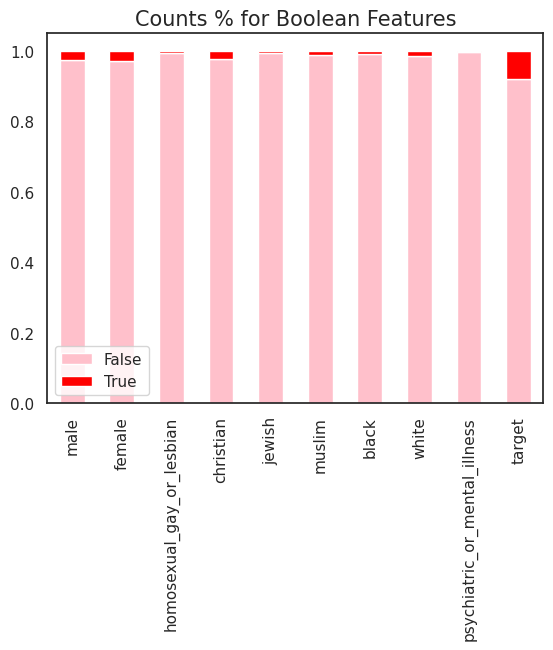

In [13]:
mydict = {}
cols = IDENTITY_COLUMNS + ['target']
for col in cols:
  mydict[col] = list(train_df[col].value_counts().values)/np.sum(train_df[col].value_counts().values)
df = pd.DataFrame(mydict, columns = cols, index = ['False', 'True']).T
sns.set(style='white')
df.set_index(df.index).plot(kind='bar', stacked=True, color=['pink', 'red'])
plt.title('Counts % for Boolean Features', fontsize=15)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Distribution of Continous Auxillary Features')

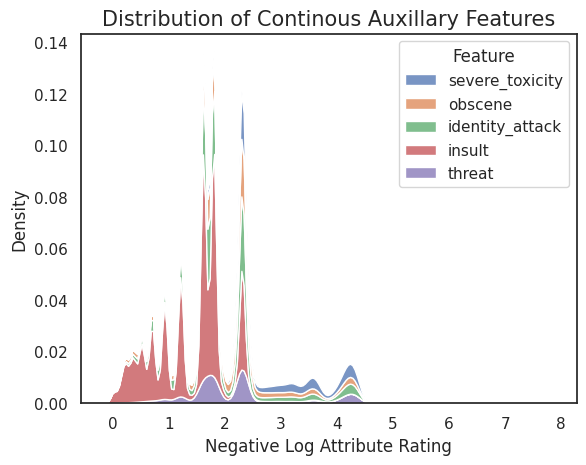

In [14]:
cols = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
val_lis = []
for col in cols:
  val_lis = val_lis + list(-np.log(train_df[col]))
feature_lis = []
for col in cols:
  feature_lis += [col]*train_df.shape[0]

df = pd.DataFrame({'Negative Log Attribute Rating': val_lis, 
                   'Feature': feature_lis
                   })
# sns.boxplot(data=df, x="Val", y="Feature", hue="Feature")
sns.kdeplot(data=df,x="Negative Log Attribute Rating", hue="Feature",multiple="stack")
plt.title('Distribution of Continous Auxillary Features', fontsize=15)

<Axes: >

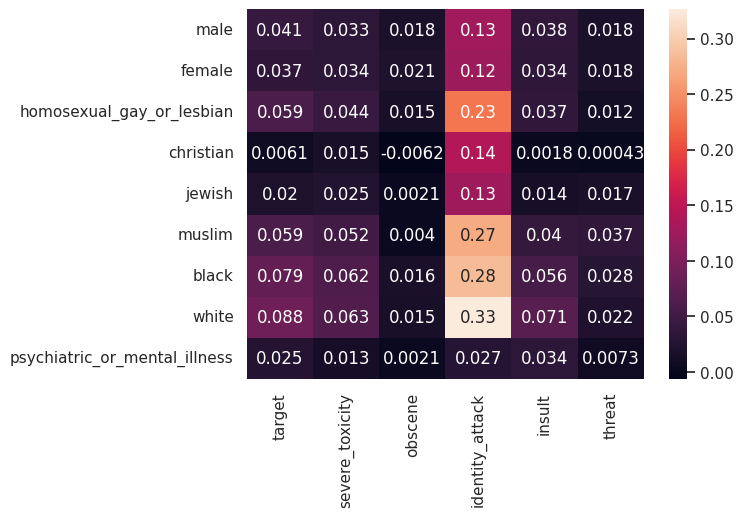

In [15]:
identity_df = train_df[IDENTITY_COLUMNS].dropna()
aux_df = train_df[AUX_COLUMNS].dropna()
identity_aux_corr = aux_df.apply(lambda s: identity_df.corrwith(s))
sns.heatmap(identity_aux_corr, annot=True)

# Training

In [16]:
x_train = tokenizer.texts_to_sequences(x_train_raw)
x_test = tokenizer.texts_to_sequences(x_test_raw)
print(f"before: x_train.shape = {len(x_train), len(x_train[0])}, x_test.shape = {len(x_test), len(x_test[0])}")
x_train = pad_sequences(x_train, maxlen=MAX_LEN)
x_test = pad_sequences(x_test, maxlen=MAX_LEN)
print(f"after: x_train.shape = {len(x_train), len(x_train[0])}, x_test.shape = {len(x_test), len(x_test[0])}")

before: x_train.shape = (1804874, 20), x_test.shape = (97320, 14)
after: x_train.shape = (1804874, 220), x_test.shape = (97320, 220)


In [17]:
# ref https://www.kaggle.com/code/thousandvoices/simple-lstm/comments#550610
sample_weights = np.ones(len(x_train), dtype=np.float32)
sample_weights += train_df[IDENTITY_COLUMNS].sum(axis=1) ## Line 2: Add 1 weight for each mention of Identity Subgroup (Subgroup AUC) ('e.g. any mention of ethnicX)
sample_weights += train_df[TARGET_COLUMN] * (~train_df[IDENTITY_COLUMNS]).sum(axis=1) ## Line 3: Add 1 weight for Abusive comment but not mentioning Identity (BPSN) (e.g. you really suck!!)
sample_weights += (~train_df[TARGET_COLUMN]) * train_df[IDENTITY_COLUMNS].sum(axis=1) * 5 ## Line 4: Add 5 weight for non-Abusive tag that mentions an Identity (e.g. you are ethnicX and it's fine !!)
sample_weights /= sample_weights.mean()

In [ ]:
embedding_matrix = np.concatenate(
    [build_matrix(tokenizer.word_index, f) for f in EMBEDDING_FILES], axis=-1)

In [ ]:
# '''save to pickle'''
# import pickle
# filehandler = open("embedding_matrix.pkl","wb")
# pickle.dump(embedding_matrix,filehandler)
# filehandler.close()


In [ ]:
'''load back'''
import pickle
file = open("embedding_matrix.pkl",'rb')
embedding_matrix = pickle.load(file)
file.close()


## Investigate sample_weights

<Axes: title={'center': 'Sample Weight Distribution'}, xlabel='Weights', ylabel='Density'>

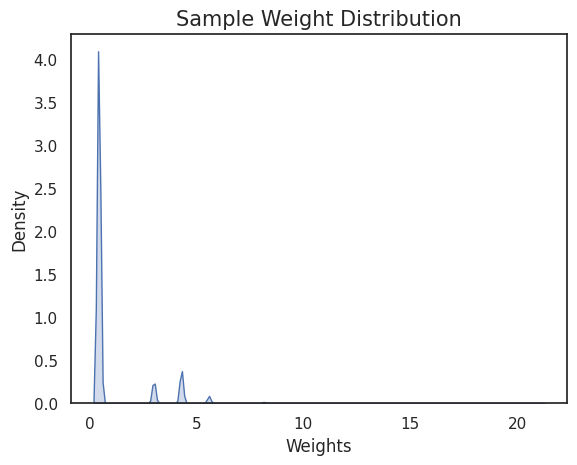

In [18]:
'''
investigate sample_weights distribution
'''
from scipy.stats import gaussian_kde

# sample_weights.describe()
# sample_weights[sample_weights!=1].plot.kde()
# plt.hist(sample_weights)
# sns.kdeplot(data=sample_weights,kde=True)
plt.title("Sample Weight Distribution", fontsize=15)
plt.xlabel("Weights")
sns.kdeplot(
   data=sample_weights,
   fill=True,)


Text(0.5, 0, 'Weights')

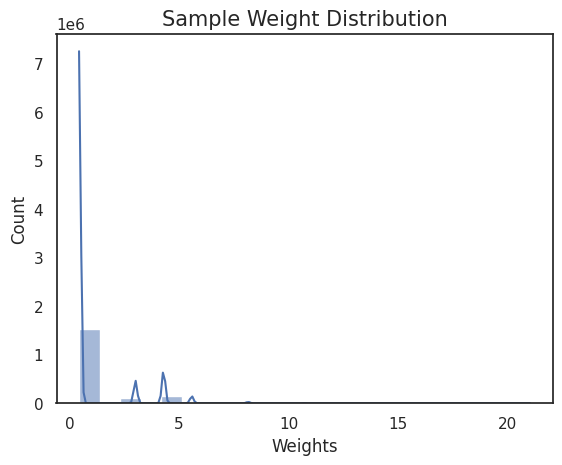

In [19]:
sns.histplot(data=sample_weights, kde=True)#, kde=False, norm_hist=True, bins=3)
plt.title("Sample Weight Distribution", fontsize=15)
plt.xlabel("Weights")

In [20]:
sample_weights.describe()

count    1.804874e+06
mean     1.000000e+00
std      1.401182e+00
min      4.293526e-01
25%      4.293526e-01
50%      4.293526e-01
75%      4.293526e-01
max      2.103828e+01
dtype: float64

In [21]:
print(len(sample_weights[sample_weights>5]))

38049


In [22]:
'''
investiagte the weights
'''
true_df = train_df[train_df['target']]
truf_df_sample_weights = sample_weights[true_df.index]
print(true_df.shape, truf_df_sample_weights.shape, len(truf_df_sample_weights[truf_df_sample_weights>4].index))
print(train_df.shape, len(sample_weights))
train_df.loc[sample_weights[sample_weights>5].index][[TEXT_COLUMN, TARGET_COLUMN]].reset_index() ## get those weight > 5.0

(144334, 45) (144334,) 144334
(1804874, 45) 1804874


index                                       comment_text  target
0          191  Thank you for this article, all I need to know...   False
1          275  I'm not a conservative, but I am ashamed to be...   False
2          483  I rather like Bernie I'm truly undecided on wh...   False
3          516  BJ, your suggestion that low income residents ...   False
4          633  Laughing at salad, white wine, wearing hospita...   False
...        ...                                                ...     ...
38044  1804687  “In the original Hebrew of the Old Testament, ...   False
38045  1804696  What exactly do you mean by "being taught how ...   False
38046  1804751  Approximately 10% of harassment complaints are...   False
38047  1804841  "It doesn't matter when it's erected and for w...   False
38048  1804858  My thought exactly.  The only people he hasn't...   False

[38049 rows x 3 columns]

In [23]:
truf_df_sample_weights.describe()

count    144334.000000
mean          4.293526
std           0.000000
min           4.293527
25%           4.293527
50%           4.293527
75%           4.293527
max           4.293527
dtype: float64

id  target                                       comment_text  \
4          59856    True               haha you guys are a bunch of losers.   
5          59859    True                               ur a sh*tty comment.   
13        239583    True  It's ridiculous that these guys are being call...   
14        239584    True  This story gets more ridiculous by the hour! A...   
19        239592    True  Angry trolls, misogynists and Racists", oh my....   
...          ...     ...                                                ...   
1804825  6333841    True  Who is the jerk in the last row between the C ...   
1804838  6333871    True  Nobody really cares that she supports the scie...   
1804856  6333923    True  Believing in God or not believing in God are p...   
1804857  6333927    True  I take your point, but I think you're shooting...   
1804872  6334009    True  Anyone who is quoted as having the following e...   

         severe_toxicity   obscene  identity_attack    insult  threat  asian  \
4               0.021277  0.000000         0.021277  0.872340     0.0    0.0   
5               0.047619  0.638095         0.000000  0.333333     0.0    NaN   
13              0.000000  0.100000         0.000000  0.600000     0.1    NaN   
14              0.000000  0.000000         0.000000  0.300000     0.0    NaN   
19              0.000000  0.000000         0.100000  0.500000     0.0    0.0   
...                  ...       ...              ...       ...     ...    ...   
1804825         0.018519  0.148148         0.000000  0.833333     0.0    NaN   
1804838         0.000000  0.100000         0.200000  0.700000     0.0    NaN   
1804856         0.000000  0.000000         0.300000  0.400000     0.0    0.0   
1804857         0.000000  0.700000         0.000000  0.600000     0.0    NaN   
1804872         0.030303  0.030303         0.045455  0.621212     0.0    NaN   

          atheist  ...    rating  funny  wow  sad  likes  disagree  \
4        0.000000  ...  rejected      0    0    0      1         0   
5             NaN  ...  rejected      0    0    0      0         0   
13            NaN  ...  approved      0    0    0      3         0   
14            NaN  ...  approved      0    0    0      9         0   
19       0.000000  ...  approved      0    0    0      0         0   
...           ...  ...       ...    ...  ...  ...    ...       ...   
1804825       NaN  ...  approved      0    0    0      0         0   
1804838       NaN  ...  approved      0    0    0      0         0   
1804856  0.857143  ...  approved      0    0    0      0         0   
1804857       NaN  ...  approved      0    0    0      0         0   
1804872       NaN  ...  approved      0    0    0      0         0   

         sexual_explicit  identity_annotator_count  toxicity_annotator_count  \
4               0.000000                         4                        47   
5               0.009524                         0                       105   
13              0.000000                         0                        10   
14              0.000000                         0                        10   
19              0.000000                         4                        10   
...                  ...                       ...                       ...   
1804825         0.000000                         0                        54   
1804838         0.000000                         0                        10   
1804856         0.000000                         7                        10   
1804857         0.000000                         0                        10   
1804872         0.000000                         0                        66   

         sample_weights  
4              4.293527  
5              4.293527  
13             4.293527  
14             4.293527  
19             4.293527  
...                 ...  
1804825        4.293527  
1804838        4.293527  
1804856        4.293527  
1804857        4.293527  
1804872        4

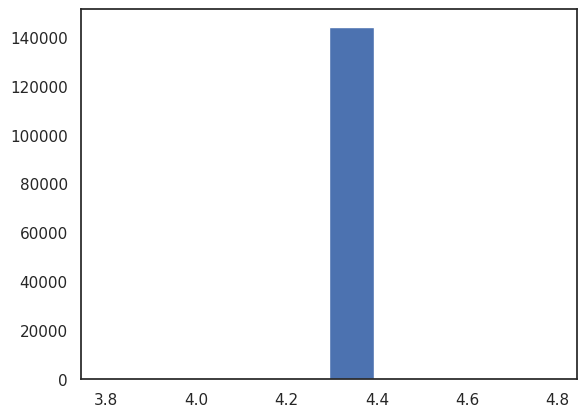

In [24]:
temp = pd.concat([train_df, pd.DataFrame(sample_weights, columns=['sample_weights'])], axis=1) 
plt.hist(temp[temp['target']]['sample_weights']) ## of those toxic, what is the sample weight distribution?
temp[temp['target']]

## Model Fitting

In [ ]:
checkpoint_predictions = []
weights = []

for model_idx in range(NUM_MODELS):
    model = build_model(embedding_matrix, y_aux_train.shape[-1])
    for global_epoch in range(EPOCHS):
        model.fit(
            x_train,
            [y_train, y_aux_train],
            batch_size=BATCH_SIZE,
            epochs=1,
            verbose=2,
            sample_weight=[sample_weights.values, np.ones_like(sample_weights)]
        )
        checkpoint_predictions.append(model.predict(x_test, batch_size=2048)[0].flatten())
        weights.append(2 ** global_epoch)

2821/2821 - 848s - loss: 0.5705 - dense_6_loss: 0.4545 - dense_7_loss: 0.1160 - 848s/epoch - 300ms/step
177/177 [==============================] - 120s 431ms/step
2821/2821 - 840s - loss: 0.5316 - dense_6_loss: 0.4239 - dense_7_loss: 0.1077 - 840s/epoch - 298ms/step
177/177 [==============================] - 74s 420ms/step
2821/2821 - 839s - loss: 0.5204 - dense_6_loss: 0.4147 - dense_7_loss: 0.1057 - 839s/epoch - 297ms/step
177/177 [==============================] - 74s 419ms/step
2821/2821 - 839s - loss: 0.5131 - dense_6_loss: 0.4087 - dense_7_loss: 0.1045 - 839s/epoch - 297ms/step
177/177 [==============================] - 74s 419ms/step
2821/2821 - 845s - loss: 0.5712 - dense_10_loss: 0.4553 - dense_11_loss: 0.1159 - 845s/epoch - 300ms/step
177/177 [==============================] - 75s 420ms/step
2821/2821 - 840s - loss: 0.5314 - dense_10_loss: 0.4238 - dense_11_loss: 0.1076 - 840s/epoch - 298ms/step
177/177 [==============================] - 74s 420ms/step
2821/2821 - 839s - loss

In [ ]:
predictions = np.average(checkpoint_predictions, weights=weights, axis=0)
submission = pd.DataFrame.from_dict({
    'id': test_df.id,
    'prediction': predictions
})

In [ ]:
test_prediction = test_df.merge(submission, on='id', how='inner')

# Evaluation

## Accuracy

In [25]:
def bpsn_auc(df, subgroup):
    subgroup_negative_examples = df.loc[(df[subgroup] == 1) & (df['target'] == 0)]
    background_positive_examples = df.loc[df[subgroup] != 1 & (df['target'] == 1)]
    examples = pd.concat([subgroup_negative_examples, background_positive_examples])
    return auc(examples['target'], examples['prediction']) 

def bnsp_auc(df, subgroup):
    subgroup_positive_examples = df.loc[(df[subgroup] == 1) & (df['target'] == 1)]
    background_negative_examples = df.loc[(df[subgroup] != 1) & (df['target'] == 0)]
    examples = pd.concat([subgroup_positive_examples, background_negative_examples])
    return auc(examples['target'], examples['prediction'])

def power_mean(df, p):
    total = sum(np.power(df, p))
    return np.power(total/len(df), 1/p)

def subgroup_bias_metrics(df, subgroups):
    results = []
    for subgroup in subgroups:
        subgroup_df = df.loc[df[subgroup] == 1]
        temp = {
            'subgroup': subgroup, 
            'subgroup_size': len(subgroup_df)
        }
        temp['subgroup_auc'] = auc(subgroup_df['target'], subgroup_df['prediction'])
        temp['bpsn_auc'] = bpsn_auc(df, subgroup)
        temp['bnsp_auc'] = bnsp_auc(df, subgroup)
        results.append(temp)
    return pd.DataFrame(results).sort_values('subgroup_auc', ascending=True).reset_index(drop=True)

def final_metrics(df, overall_auc, power=-5, metric_weight=0.25):
    bias_score = np.average([
        power_mean(df['subgroup_auc'], power),
        power_mean(df['bpsn_auc'], power),
        power_mean(df['bnsp_auc'], power)
    ])
    return (metric_weight * overall_auc) + ((1 - metric_weight)* bias_score)

In [27]:
overall_auc = auc(test_prediction['target'], test_prediction['prediction'])
print('Overall AUC is', overall_auc)
bias_metrics = subgroup_bias_metrics(test_prediction, IDENTITY_COLUMNS)
display(bias_metrics)
final_metric = final_metrics(bias_metrics, overall_auc)
print('Final Metric is', final_metric)

Overall AUC is 0.9678968066717056


subgroup  subgroup_size  subgroup_auc  bpsn_auc  \
0                          black            761      0.842024  0.929058   
1      homosexual_gay_or_lesbian            538      0.842067  0.925099   
2                         muslim           1054      0.846241  0.946483   
3                          white           1178      0.851563  0.928634   
4                         jewish            411      0.907606  0.957440   
5                           male           2112      0.923295  0.964468   
6                         female           2602      0.936724  0.974402   
7  psychiatric_or_mental_illness            238      0.936997  0.951018   
8                      christian           2109      0.940380  0.977608   

   bnsp_auc  
0  0.937138  
1  0.937546  
2  0.924560  
3  0.941786  
4  0.935474  
5  0.939268  
6  0.934392  
7  0.960423  
8  0.926534

Final Metric is 0.9350457792586925


In [28]:
test_prediction['gender'] = 'other'
test_prediction.loc[test_prediction['female']==True, 'gender'] = 'female'
test_prediction.loc[test_prediction['male']==True, 'gender'] = 'male'

test_prediction['race'] = 'other'
test_prediction.loc[test_prediction['black']==True, 'race'] = 'black'
test_prediction.loc[test_prediction['white']==True, 'race'] = 'white'

test_prediction['religion'] = 'other'
test_prediction.loc[test_prediction['christian']==True, 'religion'] = 'christian'
test_prediction.loc[test_prediction['jewish']==True, 'religion'] = 'jewish'
test_prediction.loc[test_prediction['muslim']==True, 'religion'] = 'muslim'

test_prediction['sexuality'] = 'other'
test_prediction.loc[test_prediction['homosexual_gay_or_lesbian']==True, 'sexuality'] = 'homosexual_gay_or_lesbian'

test_prediction['disability'] = 'other'
test_prediction.loc[test_prediction['psychiatric_or_mental_illness']==True, 'disability'] = 'psychiatric_or_mental_illness'

In [29]:
test_prediction['prediction'] = np.where(test_prediction['prediction'] >= 0.5, True, False)

metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'FNR': false_negative_rate,
    'FPR': false_positive_rate
}

In [30]:
sensitive_feature = test_prediction['gender']
grouped_on_sex = MetricFrame(metrics=metrics,
                             y_true=test_prediction['target'],
                             y_pred=test_prediction['prediction'],
                             sensitive_features=sensitive_feature)
grouped_on_sex.by_group

accuracy  precision    recall       FNR       FPR
gender                                                   
female  0.920364   0.817568  0.517094  0.482906  0.017717
male    0.900568   0.766990  0.493750  0.506250  0.026786
other   0.945982   0.620793  0.773778  0.226222  0.039593

In [31]:
sensitive_feature = test_prediction['race']
grouped_on_sex = MetricFrame(metrics=metrics,
                             y_true=test_prediction['target'],
                             y_pred=test_prediction['prediction'],
                             sensitive_features=sensitive_feature)
grouped_on_sex.by_group.reindex(['black', 'white', 'other'])

accuracy  precision    recall       FNR       FPR
race                                                    
black  0.805383   0.785714  0.464789  0.535211  0.052786
white  0.792869   0.773869  0.436261  0.563739  0.054545
other  0.947104   0.622438  0.775611  0.224389  0.038766

In [32]:
sensitive_feature = test_prediction['religion']
grouped_on_sex = MetricFrame(metrics=metrics,
                             y_true=test_prediction['target'],
                             y_pred=test_prediction['prediction'],
                             sensitive_features=sensitive_feature)
grouped_on_sex.by_group

accuracy  precision    recall       FNR       FPR
religion                                                    
christian  0.945813   0.800000  0.470588  0.529412  0.010753
jewish     0.886154   0.777778  0.403846  0.596154  0.021978
muslim     0.834915   0.775701  0.356223  0.643777  0.029233
other      0.945938   0.623234  0.775583  0.224417  0.039654

In [33]:
sensitive_feature = test_prediction['sexuality']
grouped_on_sex = MetricFrame(metrics=metrics,
                             y_true=test_prediction['target'],
                             y_pred=test_prediction['prediction'],
                             sensitive_features=sensitive_feature)
grouped_on_sex.by_group

accuracy  precision    recall       FNR       FPR
sexuality                                                                   
homosexual_gay_or_lesbian  0.795539   0.750000  0.428571  0.571429  0.057292
other                      0.945362   0.625957  0.761118  0.238882  0.038886

In [34]:
sensitive_feature = test_prediction['disability']
grouped_on_sex = MetricFrame(metrics=metrics,
                             y_true=test_prediction['target'],
                             y_pred=test_prediction['prediction'],
                             sensitive_features=sensitive_feature)
grouped_on_sex.by_group.reindex(['psychiatric_or_mental_illness', 'other'])

accuracy  precision    recall       FNR  \
disability                                                               
psychiatric_or_mental_illness  0.899160   0.826087  0.703704  0.296296   
other                          0.944645   0.626141  0.754888  0.245112   

                                    FPR  
disability                               
psychiatric_or_mental_illness  0.043478  
other                          0.038955

## Fairness

In [35]:
sensitive_feature = ['gender', 'race', 'religion', 'sexuality', 'disability']
fnr_diff = []
fpr_diff = []
demo_parity_ratio = []
equal_odds_ratio = []
select_rate_diff = []
for feature in sensitive_feature:
    fnr_diff.append(false_negative_rate_difference(test_prediction['target'], test_prediction['prediction'], 
                                                   sensitive_features=test_prediction[feature]))
    fpr_diff.append(false_positive_rate_difference(test_prediction['target'], test_prediction['prediction'], 
                                                   sensitive_features=test_prediction[feature]))
    demo_parity_ratio.append(demographic_parity_ratio(test_prediction['target'], test_prediction['prediction'], 
                                                   sensitive_features=test_prediction[feature]))
    equal_odds_ratio.append(equalized_odds_ratio(test_prediction['target'], test_prediction['prediction'], 
                                                   sensitive_features=test_prediction[feature]))
    select_rate_diff.append(selection_rate_difference(test_prediction['target'], test_prediction['prediction'], 
                                                   sensitive_features=test_prediction[feature]))

In [36]:
fairness_df = pd.DataFrame({'fnr_difference':fnr_diff, 'fpr_difference': fpr_diff, 
                            'demographic_parity_ratio': demo_parity_ratio, 'equalized_odds_ratio': equal_odds_ratio,
                            'selection_rate_difference': select_rate_diff}, index=sensitive_feature)
fairness_df

fnr_difference  fpr_difference  demographic_parity_ratio  \
gender            0.280028        0.021877                  0.863117   
race              0.339350        0.015780                  0.545432   
religion          0.419359        0.028902                  0.485245   
sexuality         0.332546        0.018406                  0.585515   
disability        0.051184        0.004523                  0.496223   

            equalized_odds_ratio  selection_rate_difference  
gender                  0.447464                   0.013351  
race                    0.562473                   0.079055  
religion                0.271161                   0.052257  
sexuality               0.563082                   0.067797  
disability              0.895970                   0.097369

## LIME

In [37]:
'''
get the sample weights with the highest weight
'''
import random
random.seed(123)

x_train_raw_lis = x_train_raw.tolist()
df = sample_weights.reset_index()
df.columns=['old_index', 'sample_weight']
df = df.sort_values(by=['sample_weight'], ascending=False) ## sort by weights descending
df['text'] = [x_train_raw_lis[i] for i in df.index]
df['label'] =  [y_train[i] for i in df.index]
df.head(10)

old_index  sample_weight  \
367273      367273      21.038280   
1379615    1379615      21.038280   
558528      558528      18.462164   
631186      631186      18.462164   
295360      295360      18.462164   
510327      510327      18.462164   
1552957    1552957      18.462164   
78635        78635      18.462164   
943757      943757      18.462164   
1464061    1464061      18.462164   

                                                      text  label  
367273   Bigotry must be confronted directly; the sides...    0.0  
1379615  tempersdue - \n\nMy comment and this article i...    0.0  
558528   Thanks for the confirmation of my supposition ...    0.3  
631186   Maybe we can be be inclusive by not highlighti...    0.4  
295360   You noticed? Or antisemitism, Or  white suprem...    0.3  
510327   "...it is absolutely appropriate that Islam is...    0.0  
1552957  "Edible pieces of art" enjoy no "protected cla...    0.3  
78635    Thank you Ward: that was a wonderful Ali inter...    0.4  
943757   Tobin should welcome everyone to the cathedral...    0.0  
1464061  " I'm not thinking about abortion on a daily b...    0.2

In [ ]:
# !pip install lime

In [ ]:
'''
LIME:
https://towardsdatascience.com/interpreting-an-lstm-through-lime-e294e6ed3a03
https://lime-ml.readthedocs.io/en/latest/lime.html#lime.lime_text.LimeTextExplainer.explain_instance
'''
from lime.lime_text import LimeTextExplainer
class_names=['negative','positive']
explainer= LimeTextExplainer(class_names=class_names)
def predict_proba(arr):
  # processed=[]
  # for i in arr:
  #   processed.append(process_text(i))
  list_tokenized_ex = tokenizer.texts_to_sequences(arr)
  Ex = pad_sequences(list_tokenized_ex, maxlen=MAX_LEN)

  pred, aux = model.predict(Ex)
  returnable=[]
  for i in pred:
    temp=i[0]
    returnable.append(np.array([1-temp,temp])) #I would recommend rounding temp and 1-temp off to 2 places
  return np.array(returnable)


In [ ]:
'''
navigate hard trainning samples: head 3 and tail 3
'''
i_lis = df.head(3).index.values.tolist() + df.tail(3).index.values.tolist()
for i in i_lis:
  print(f"gt index = {i}")
  print(f"gt label = {y_train[i]}")
  # print(f"gt text: {x_train_raw_lis[i]}")
  print(f"weight = {df.loc[i]['sample_weight']}")
  print(f"gt aux: {[item for item in list(zip(AUX_COLUMNS, y_aux_train[i]))]}")
  explainer.explain_instance(x_train_raw_lis[i],predict_proba).show_in_notebook(text=True)


### navigate OOD samples, FN

In [38]:
'''
accuracy eval
'''
print("Accuracy of the model : ", accuracy_score(test_prediction['prediction'], test_prediction['target']))
print('F1-score: ', f1_score(test_prediction['prediction'], test_prediction['target']))
print(f"Confusion matrix: \n{confusion_matrix(test_prediction['prediction'], test_prediction['target'])}")

Accuracy of the model :  0.9445334977394163
F1-score:  0.6849538928446364
Confusion matrix: 
[[86054  1909]
 [ 3489  5868]]


In [39]:
''' 
find the fn
'''
import itertools
gt_1 = np.argwhere(np.array(test_prediction['target'])==int(1.0))
gt_1 = list(itertools.chain.from_iterable(gt_1))

pred_0 = np.argwhere(np.array(test_prediction['prediction'])==int(0.0))
pred_0 = list(itertools.chain.from_iterable(pred_0))

fn = set(gt_1).intersection(set(pred_0))
print(len(fn))

1909


In [40]:
''' 
find the fp
'''
import itertools
gt_0 = np.argwhere(np.array(test_prediction['target'])==int(0.0))
gt_0 = list(itertools.chain.from_iterable(gt_0))

pred_1 = np.argwhere(np.array(test_prediction['prediction'])==int(1.0))
pred_1 = list(itertools.chain.from_iterable(pred_1))

fp = set(gt_0).intersection(set(pred_1))
print(len(fp))

3489


In [ ]:
'''
navigate OOD samples, FP
'''
random.seed(123)
i_lis = random.sample(fp, 3)

for i in i_lis:
  print(f"gt index = {i}")
  print(f"gt label = {y_test[i]}, gt argmax = {test_prediction['target'][i]}, pred = {test_prediction['prediction'][i]}")
  # print(f"gt text: {x_train_raw_lis[i]}")
  print(f"gt aux: {[item for item in list(zip(AUX_COLUMNS, y_aux_test[i]))]}")
  explainer.explain_instance(x_test_raw.tolist()[i],predict_proba).show_in_notebook(text=True)

In [ ]:
'''
navigate OOD samples
'''
random.seed(123)
i_lis = random.sample(fn, 5)

for i in i_lis:
  print(f"gt index = {i}")
  print(f"gt label = {y_test[i]}")
  # print(f"gt text: {x_train_raw_lis[i]}")
  print(f"gt aux: {[item for item in list(zip(AUX_COLUMNS, y_aux_test[i]))]}")
  explainer.explain_instance(x_test_raw.tolist()[i],predict_proba).show_in_notebook(text=True)

<ipython-input-156-110c22b7ea72>:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  i_lis = random.sample(fn, 5)


gt index = 10637
gt label = 0.816326530612245
gt aux: [('target', 0.816326530612245), ('severe_toxicity', 0.0408163265306122), ('obscene', 0.1020408163265306), ('identity_attack', 0.0204081632653061), ('insult', 0.816326530612245), ('threat', 0.0)]
157/157 [==============================] - 2s 15ms/step


gt index = 185146
gt label = 0.8
gt aux: [('target', 0.8), ('severe_toxicity', 0.0), ('obscene', 0.0), ('identity_attack', 0.0), ('insult', 0.8), ('threat', 0.0)]
157/157 [==============================] - 2s 15ms/step


gt index = 17950
gt label = 0.0
gt aux: [('target', 0.0), ('severe_toxicity', 0.0), ('obscene', 0.0), ('identity_attack', 0.0), ('insult', 0.0), ('threat', 0.0)]
157/157 [==============================] - 2s 15ms/step


gt index = 82074
gt label = 0.0
gt aux: [('target', 0.0), ('severe_toxicity', 0.0), ('obscene', 0.0), ('identity_attack', 0.0), ('insult', 0.0), ('threat', 0.0)]
157/157 [==============================] - 2s 15ms/step


gt index = 316018
gt label = 0.7826086956521741
gt aux: [('target', 0.7826086956521741), ('severe_toxicity', 0.0652173913043478), ('obscene', 0.0652173913043478), ('identity_attack', 0.0), ('insult', 0.7826086956521741), ('threat', 0.0)]
157/157 [==============================] - 2s 15ms/step
